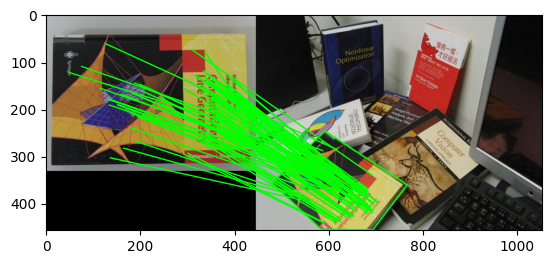

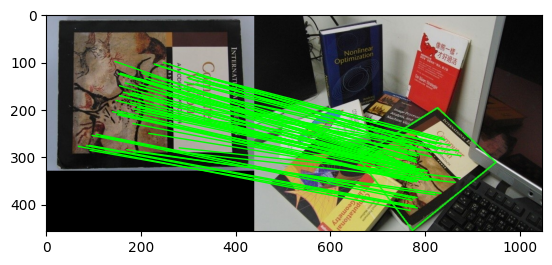

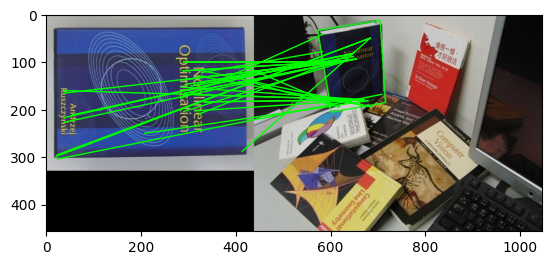

In [2]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# SIFT interest point detection and matching
def sift_detection_and_matching(image1, image2, point, threshold):

    img1 = cv2.imread(image1)
    img2 = cv2.imread(image2)

    # SIFT interest point detection
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)


    # SIFT feature matching
    match1=[]
    dis = np.zeros(np.shape(des1))
    for i in range(des1.shape[0]):
        if np.std(des1[i,:]) != 0:
            dis = des2-des1[i,:]
            dis = np.linalg.norm(dis, axis=1)
            arrange = np.argsort(dis).tolist()
            if dis[arrange[0]]/dis[arrange[1]] <= threshold:
                match1.append((i,arrange[0]))

    match2=[]
    for i in range(des2.shape[0]):
        if np.std(des2[i,:]) != 0:
            dis=des1-des2[i,:]
            dis=np.linalg.norm(dis, axis=1)
            arrange =np.argsort(dis).tolist()
            if dis[arrange[0]]/dis[arrange[1]] <= threshold:
                match2.append((arrange[0],i))
            
    match = list(set(match1).intersection(set(match2)))
    matches = [cv2.DMatch(i[0], i[1], 1) for i in match]

    # Plot the detected interest points and point correspondences
    draw_params = dict(matchColor = (0,255,0),
                        singlePointColor = (0,165,255),
                        flags = 0)
    
    matching = cv2.drawMatches(img1, kp1, img2, kp2, matches[:point], None,**draw_params)
    cv2.imwrite("sift-%s.jpg" %(image1), matching)


def select_keypoints_in_bbox(descriptors, keypoints, bbox):
    xmin, ymin, xmax, ymax = bbox
    indices = [i for i, pt in enumerate(keypoints) if 
            pt[0] >= xmin and pt[0] <= xmax and pt[1] >= ymin and pt[1] <= ymax]
    return descriptors[indices, :], keypoints[indices, :]


def ransac_homography_transformationgraphy(image1, image2, obj_bbox, num_iterations, threshold):

    img1 = plt.imread(image1)
    img2 = plt.imread(image2)
    # SIFT interest point detection
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    



        
    kpArray1 = []
    for i in range(len(kp1)):
        kpArray1.append(kp1[i].pt)
    

    kpArray1 = np.array(kpArray1)

    kpArray2 = []
    for i in range(len(kp2)):
        kpArray2.append(kp2[i].pt)
    

    kpArray2 = np.array(kpArray2)
    # obj_bbox = [134, 13, 277, 207]




    des2, kpArray2, = select_keypoints_in_bbox(des2, kpArray2, obj_bbox)

    n = des1.shape[0]
    matches = np.empty((0,2), int)

    for i in range(n):
        feature = des1[i]
        distances = np.linalg.norm(des2 - feature,axis=1)
        idx = np.argsort(distances)
        

        if distances[idx[0]] < threshold * distances[idx[1]]:
            match = np.array([i,idx[0]]).reshape(1,2)
            matches = np.vstack((matches,match))


    n = matches.shape[0]


    seq = [i for i in range(n)]
    valid_sample = [i for i in range(4,n)]

    
    inliers = np.array([])
    H_best = np.zeros((3,3))





    
    pts_homo = np.ones((kpArray1.shape[0],3))
    pts_homo[:,:-1] = kpArray1[:,:2]
    # print(pts_homo)
    

    for _ in range(num_iterations):
        
        # valid sample subset 
        sample_length = random.sample(valid_sample, 1)[0]
        sample = random.sample(seq,sample_length)

        
        candit = matches[sample]


        # 1st image coordinates
        pts = pts_homo[candit[:,0]]
        pts_prime = kpArray2[candit[:,1],:2]
        
        A = np.zeros((sample_length*2,9))
        
        # homography
        for i in range(sample_length):


            A[i*2,3:6]  = -pts[i]
            A[i*2,6:]   = pts[i] * pts_prime[i,1]
            A[i*2+1,:3] = pts[i]
            A[i*2+1,6:] = -pts[i] * pts_prime[i,0]

        
        u,s,vh = np.linalg.svd(A)
        H = vh[-1].reshape(3,3)
        
        # reprojection error
        reprojection_threshold = 10
        pts_reproj_homo = H.dot(pts_homo[matches[:,0]].T)
        pts_reproj_inhomo = pts_reproj_homo[:-1,:] / pts_reproj_homo[-1,:]
        error = np.linalg.norm(kpArray2[matches[:,1],:2]-pts_reproj_inhomo.T,axis=1)
        inlier_idx = np.where(error < reprojection_threshold)[0]
        
        if len(inliers) < len(inlier_idx):
            inliers = inlier_idx



    fig = plt.figure()
    new_im = np.zeros((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], max(img1.shape[2], img2.shape[2])),dtype=np.uint8)
    new_im[:img1.shape[0], :img1.shape[1], :img1.shape[2]] = img1
    new_im[:img2.shape[0], img1.shape[1]:, :img2.shape[2]] = img2
    plt.imshow(new_im)
    plt.autoscale(False)


    for m in matches:
        ind1, ind2 = m
        plt.plot([kpArray1[ind1,0], img1.shape[1]+kpArray2[ind2,0]], [kpArray1[ind1,1], kpArray2[ind2,1]],  color='lime', linewidth=1.0)
    plt.savefig('ransac-%s.jpg' %(image1)) 

       
    # return inliers, H_best

def comput_obj_bbox(image, points):

    image = cv2.imread(image)

    img = image.copy()


    x = []; y = []
    for i in range(len(points)):
        x.append(points[i, 0])
        y.append(points[i, 1])
    
    x_min = min(x); x_max = max(x)
    y_min = min(y); y_max = max(y)

    obj_bbox = [x_min, y_min, x_max, y_max]

    cv2.polylines(img,[points],True,(0,255,0),2)



    cv2.imwrite("img.jpg" , img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    name = "img.jpg"
    return name, obj_bbox 

if __name__ == '__main__': 
    
    image = "1-image.jpg"
    image1 = "1-book1.jpg"
    image2 = "1-book2.jpg"
    image3 = "1-book3.jpg"

    
    pts1 = np.array([[146,247], [321,361], [248, 456], [138, 455], [34, 357]])
    pts2 = np.array([[387,197], [510, 312], [334, 455], [219, 302]])
    pts3 = np.array([[134,34], [266,13], [277, 186], [163, 206]])


    sift_detection_and_matching(image1, image, point=1000, threshold=0.6)
    sift_detection_and_matching(image2, image, point=1000, threshold=0.4)
    sift_detection_and_matching(image3, image, point=1000, threshold=0.8)

    img1, obj_bbox1 = comput_obj_bbox(image, pts1)
    ransac_homography_transformationgraphy(image1, img1, obj_bbox1, num_iterations = 1000, threshold = 0.6)

    img2, obj_bbox2 = comput_obj_bbox(image, pts2)
    ransac_homography_transformationgraphy(image2, img2, obj_bbox2, num_iterations = 1000, threshold = 0.4)

    img3, obj_bbox3 = comput_obj_bbox(image, pts3)
    ransac_homography_transformationgraphy(image3, img3, obj_bbox3, num_iterations = 1000, threshold = 0.8)


    
